# Общие сведения

Ниже рассматриваеться реализация Continuous Bag-of-words(CBOW) подхода к задаче word2vec.

In [1]:
import numpy as np

import torch
import torch.nn as nn

from torchtext.legacy.data import Field, Dataset, Example
from torch.autograd import Variable
import torch.nn.functional as F


import gensim.downloader as api
import time

Загрузим датасет text8 из gensim, данный датасет уже предобработан, что позволит нам не отвлекаться на препроцессинг.

In [36]:
dataset = api.load("text8")
data = [d for d in dataset]
print(data[0][:30])

train_data = ' '.join(data[0])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


Идея работы CBOW заключается в том, чтоб по эмбеддингам слов, которые стоят рядом, т.е. по контексту, предсказать слово, принадлежащее этому контексту. Схематично логика работы изображена ниже.

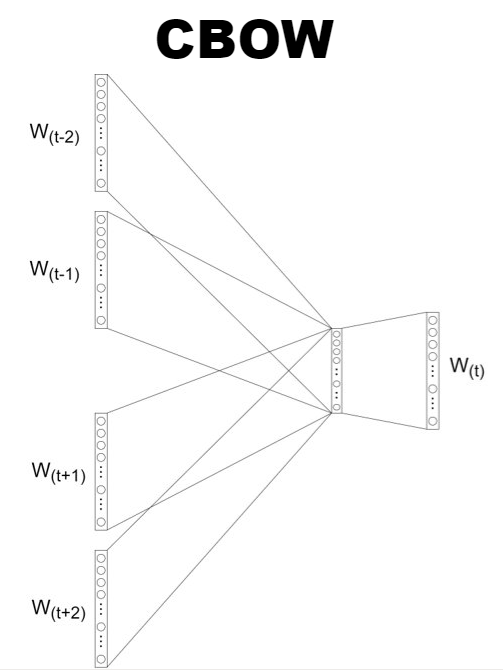

Составим словарь для нашего текста, во избежание случая, когда для одного слова посчитано два эмбеддинга.

In [3]:
vocabulary = ['<pad>'] + list(set(train_data.split()))

У CBOW есть важный параметр - размер окна, который определяет по сколько слов спереди и сзади будут считаться контекстом слова-таргета.

In [4]:
window_size = 5

# спереди и сзади добавим паддинги, для удобства при формировании датасета
padded_text = ['<pad>']*window_size + train_data.split() + ['<pad>']*window_size

In [5]:
# слова-таргеты совпадают с исходным текстом
targets = train_data.split()

# каждому слову-таргету соответствуют window_size*2 слов стоящих спереди и сзади во входном тексте
# для слов стоящих в начале и в конце теста контекст будет неполным, отсутствующие слова заменят <pad> токены
contexts = [padded_text[i-window_size:i]+padded_text[i+1:i+1+window_size] \
                      for i in range(window_size, len(padded_text)-window_size)]


In [6]:
# так же для удобства создадим словарик, в котором каждому слову соответствует его индекс в словаре
word2idx = {word: idx for (idx, word) in enumerate(vocabulary)}

Ниже представлен внешний вид датасета (начало исходного текста для наглядности)

In [37]:
print(' '.join(train_data.split()[:10]) + '\n')
print(targets[0])
print(contexts[0])

anarchism originated as a term of abuse first used against

anarchism
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'originated', 'as', 'a', 'term', 'of']


Ниже представлена модель, реализующая обучение CBOW. По контексту слова выделяются эмбеддинги, усредняются до одного вектора, который проходит через матрицу весов. Размерность выхода модели равна размеру словаря, что позволяет интерпретировать выход модели как веротность встретить то или иное слово в данном конексте.

In [8]:
class CBOW(nn.Module):
    def __init__(self, input_dim, window, hidden_dim, output_dim):

      super().__init__()

      self.token_embedding = nn.Embedding(input_dim, hidden_dim, padding_idx=0)

      self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, words):
        x = self.token_embedding(words)

        x = x.mean(axis=0)

        x = self.classifier(x)

        return x

# Обучение модели

Ниже небольшая торчевская рутина по обучению модели

In [9]:
input_dim = len(vocabulary)
window = window_size
hidden_dim = 640 # размерность эмбеддинга
output_dim = len(vocabulary)
lr = 0.025

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = CBOW(input_dim, window, hidden_dim, output_dim).to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_function = nn.CrossEntropyLoss()

In [12]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
epochs = 10

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    start_time = time.time()
    for target, context in zip(targets, contexts):

        x = torch.IntTensor(np.unique([word2idx[c] for c in context])).to(device)
        y = torch.LongTensor([word2idx[target]]).to(device)

        optimizer.zero_grad()

        output = model(x).unsqueeze(0)

        loss = loss_function(output, y)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch} | Time: {epoch_mins}m {epoch_secs}s')
    print(f"epoch_loss = {epoch_loss / len(targets)}")

Epoch: 0 | Time: 0m 31s
epoch_loss = 35.64939431148309
Epoch: 1 | Time: 0m 30s
epoch_loss = 42.06944564253651
Epoch: 2 | Time: 0m 31s
epoch_loss = 38.78078666359312
Epoch: 3 | Time: 0m 31s
epoch_loss = 44.364573613852556
Epoch: 4 | Time: 0m 31s
epoch_loss = 43.05525388616924
Epoch: 5 | Time: 0m 31s
epoch_loss = 38.48347448924694
Epoch: 6 | Time: 0m 31s
epoch_loss = 34.51304446927907
Epoch: 7 | Time: 0m 31s
epoch_loss = 31.92882414796389
Epoch: 8 | Time: 0m 31s
epoch_loss = 30.17248543450638
Epoch: 9 | Time: 0m 31s
epoch_loss = 26.617302052740527


# Подробнее о работе модели

Посмотрим более подробно на работу модели

In [24]:
class CBOW(nn.Module):
    def __init__(self, input_dim, window, hidden_dim, output_dim):

      super().__init__()

      self.token_embedding = nn.Embedding(input_dim, hidden_dim, padding_idx=0)

      self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, words):
        x = self.token_embedding(words)
        print("Эмбеддинги слов контекста")
        print(x)
        print()

        x = x.mean(axis=0)
        print("Усредненный эмбеддинг контекста")
        print(x)
        print()

        x = self.classifier(x)
        print("Выход классификатора (совпадает с размером словаря)")
        print(x)
        print()

        return x

model = CBOW(input_dim, window, 5, output_dim).to(device) # установим размерность эмбеддинга равным 5

In [25]:
model.eval()

x = torch.IntTensor(np.unique([word2idx[c] for c in contexts[0]])).to(device)
y = torch.LongTensor([word2idx[targets[0]]]).to(device)

print("Слова из контекста")
print(contexts[0])
print()

print("Индексы слов из контекста")
print(x)
print()

output = model(x)

Слова из контекста
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'originated', 'as', 'a', 'term', 'of']

Индексы слов из контекста
tensor([   0,  926, 1104, 1263, 1669, 2358], device='cuda:0',
       dtype=torch.int32)

Эмбеддинги слов контекста
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8437, -0.1171, -0.4760,  0.1170, -1.4202],
        [ 0.3001,  0.5210, -0.6363,  0.2451, -0.3918],
        [-0.3607, -0.0630, -0.3019, -0.0062,  0.7847],
        [ 0.1809, -2.7755, -0.9342, -0.0679,  0.0059],
        [ 0.4886,  0.2605,  0.6972,  1.3910,  0.5007]], device='cuda:0',
       grad_fn=<EmbeddingBackward0>)

Усредненный эмбеддинг контекста
tensor([ 0.2421, -0.3623, -0.2752,  0.2798, -0.0868], device='cuda:0',
       grad_fn=<MeanBackward1>)

Выход классификатора (совпадает с размером словаря)
tensor([ 0.0672,  0.3875, -0.1039,  ..., -0.2915, -0.0782,  0.0051],
       device='cuda:0', grad_fn=<AddBackward0>)



In [26]:
print(len(output) == len(vocabulary))

True


Для получения слова, которое модель посчитала как самое вероятное для данного контекста нужно взять индекс самого большого значения из модели и получить соответствующее слово из словаря.

In [30]:
vocabulary[output.argmax()]

'believing'

# Функция декоратор

В функцию ниже собран весь код для обучения, на вход достаточно подать предобработанный текст, в ответ вернет словарь слово:эмбеддинг.

In [34]:
def train_embeddings_CBOW(train_data: str,
                          window_size: int=5,
                          hidden_dim: int=10,
                          lr: float=0.01,
                          epoch_num: int=10):
    """
    get: text

    return: Word2Vec_dict: dict
            - key: string (word)
            - value: np.array (embedding)
    """
    
    splitted = train_data.split()

    vocabulary = ['<pad>'] + list(set(splitted))

    window_size = window_size

    train_vocabulary = ['<pad>']*window_size + splitted + ['<pad>']*window_size

    targets = splitted
    contexts = [train_vocabulary[i-window_size:i]+train_vocabulary[i+1:i+1+window_size] for i in range(window_size, len(train_vocabulary)-window_size)]

    word2idx = {word: idx for (idx, word) in enumerate(vocabulary)}

    class CBOW(nn.Module):
        def __init__(self, input_dim, window, hidden_dim, output_dim):

          super().__init__()

          self.token_embedding = nn.Embedding(input_dim, hidden_dim, padding_idx=0)

          self.classifier = nn.Linear(hidden_dim, output_dim)

        def forward(self, words):
            x = self.token_embedding(words)
            x = x.mean(axis=0)
            x = self.classifier(x)
            return x

    input_dim = len(vocabulary)
    window = window_size
    hidden_dim = hidden_dim
    output_dim = len(vocabulary)
    lr = lr

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = CBOW(input_dim, window, hidden_dim, output_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    loss_function = nn.CrossEntropyLoss()

    epochs = epoch_num

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for target, context in zip(targets, contexts):
            
            x = torch.IntTensor(np.unique([word2idx[c] for c in context])).to(device)
            y = torch.LongTensor([word2idx[target]]).to(device)

            optimizer.zero_grad()

            output = model(x).unsqueeze(0)

            loss = loss_function(output, y)

            loss.backward()
            
            optimizer.step()

    embeddings = model.token_embedding.weight.tolist()

    return {token:np.array(emb) for token, emb in zip(vocabulary[1:], embeddings[1:])}

In [35]:
embeddings = train_embeddings_CBOW(train_data)
embeddings['music']

array([2.79836965, 0.66988814, 1.24391794, 2.28546095, 0.6384871 ,
       3.21377921, 1.1485368 , 1.30727327, 0.84682679, 2.15901637])